In [3]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import natsort
from tqdm import tqdm

# Create Data

In [2]:
metadata = {
    1: {"tumble_dryer": 4, "washing_machine": 5, "dishwasher": 6},
    2: {"washing_machine": 2, "dishwasher": 3},
#     3: {"tumble_dryer": 4, "washing_machine": 6, "dishwasher": 5}, # aggregate contains solar
    4: {"washing_machine": 4, "washing_machine_2": 5},
    5: {"tumble_dryer": 2, "washing_machine": 3, "dishwasher": 4},
    6: {"washing_machine": 2, "dishwasher": 3},
    7: {"tumble_dryer": 4, "washing_machine": 5, "dishwasher": 6},
    8: {"tumble_dryer": 3, "washing_machine": 4},
    9: {"tumble_dryer": 2, "washing_machine": 3, "dishwasher": 4},
    10: {"washing_machine": 5, "dishwasher": 6},
#     11: {"washing_machine": 3, "dishwasher": 4},  # Dishwasher changed 2014-10-04, # aggregate contains solar
    4: {"washing_machine": 4, "washing_machine_2": 5},
    13: {"washing_machine": 3, "dishwasher": 4},  # Washing machine changed 2015-03-25
    15: {"tumble_dryer": 2, "washing_machine": 3, "dishwasher": 4},
    16: {"washing_machine": 5, "dishwasher": 6},
    17: {"tumble_dryer": 3, "washing_machine": 4},
    18: {"tumble_dryer": 4, "washing_machine": 5, "dishwasher": 6},
    19: {"washing_machine": 2},
    20: {"tumble_dryer": 3, "washing_machine": 4, "dishwasher": 5},
#     21: {"tumble_dryer": 2, "washing_machine": 3, "dishwasher": 4}, # aggregate contains solar
}

output_dir = "..\\data\\refit_visualize"
input_csv_dir = "D:\SCCER-Publikation\load-shifting-potential-master\data\CLEAN_REFIT_081116"
# output_col_prefix = "X_"
output_sample_rate = "1T"
output_file_suffix = ""

def load_house_df(csv_path, appliances):
    cols = ["Unix", "Aggregate"]
    for appliance_number in appliances.values():
        cols.append("Appliance{}".format(appliance_number))
    house_df = pd.read_csv(csv_path, usecols=cols)

    house_df_data = {"total_cons_power": house_df["Aggregate"]}
    for appliance_name, appliance_number in appliances.items():
        house_df_data["{}_power".format(appliance_name)] = house_df[
            "Appliance{}".format(appliance_number)
        ].values
    index = pd.DatetimeIndex(
        pd.to_datetime(house_df["Unix"], unit="s", utc=True).rename(None)
    ).tz_convert("Europe/London")
    house_df = pd.DataFrame(house_df_data).set_index(index)
    house_df.sort_index(inplace=True)

    return house_df

for house_number, appliances in tqdm(metadata.items()):
    csv_path = os.path.join(input_csv_dir, "CLEAN_House{}.csv".format(house_number))
    house_df = load_house_df(csv_path, appliances)

#    joined_df = house_df.join(solar_df, how="outer").add_prefix(args.output_col_prefix)
    joined_df = house_df.resample(output_sample_rate).mean()
#    joined_df = joined_df["2014-05-03":"2015-05-02"]
    joined_df = joined_df.dropna()
    if joined_df.empty:
        raise ValueError("joined_df is empty")

    filename = (
        "house_{}_{}{}.hdf".format(house_number, output_sample_rate, output_file_suffix)
    )
    joined_df.to_hdf(
        os.path.join(output_dir, filename),
        key="/data",
        complevel=9,
        complib="blosc:snappy",
    )

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:37<00:00,  5.14s/it]


In [3]:
joined_df.head()

,dishwasher_power,total_cons_power,tumble_dryer_power,washing_machine_power
2014-03-07 16:20:00+00:00,0.0,2323.000000,0.0,2094.666667
2014-03-07 16:21:00+00:00,0.0,2337.428571,0.0,2094.571429
2014-03-07 16:22:00+00:00,0.0,507.875000,0.0,69.500000
2014-03-07 16:23:00+00:00,0.0,236.400000,0.0,73.700000
2014-03-07 16:24:00+00:00,0.0,211.900000,0.0,71.200000


# Visualize


In [4]:
# load data
list_of_files = glob.glob('..\\data\\refit_visualize\\*')
list_of_files = natsort.natsorted(list_of_files, key=lambda y: y.lower())
list_of_files

['..\\data\\refit_visualize\\house_1_1T.hdf',
 '..\\data\\refit_visualize\\house_2_1T.hdf',
 '..\\data\\refit_visualize\\house_4_1T.hdf',
 '..\\data\\refit_visualize\\house_5_1T.hdf',
 '..\\data\\refit_visualize\\house_6_1T.hdf',
 '..\\data\\refit_visualize\\house_7_1T.hdf',
 '..\\data\\refit_visualize\\house_8_1T.hdf',
 '..\\data\\refit_visualize\\house_9_1T.hdf',
 '..\\data\\refit_visualize\\house_10_1T.hdf',
 '..\\data\\refit_visualize\\house_13_1T.hdf',
 '..\\data\\refit_visualize\\house_15_1T.hdf',
 '..\\data\\refit_visualize\\house_16_1T.hdf',
 '..\\data\\refit_visualize\\house_17_1T.hdf',
 '..\\data\\refit_visualize\\house_18_1T.hdf',
 '..\\data\\refit_visualize\\house_19_1T.hdf',
 '..\\data\\refit_visualize\\house_20_1T.hdf']

In [5]:
list_of_df = []
for file in list_of_files:
    df = pd.read_hdf(file)
    df = df.dropna()
    df = df[['total_cons_power']]
    # group into quarter days
    df = df.groupby(pd.Grouper(level=0, freq='6h')).agg(len)
    df = df[df['total_cons_power'] >= 180]
    # rename columns
    filename = os.path.basename(file)
    filename = filename.split('.')[0]
    fn_parts = filename.split('_')
    df = df.rename(columns={'total_cons_power': "{}_{}".format(fn_parts[0], fn_parts[1])})
    # add value for display purpose
    m = int(fn_parts[1]) 
#     print(df.sample(20))
    df = df.notna()*m
    list_of_df.append(df)
df_all = pd.concat(list_of_df, axis=1)    
df_all.head()

,house_1,house_2,house_4,house_5,house_6,house_7,house_8,house_9,house_10,house_13,house_15,house_16,house_17,house_18,house_19,house_20
2013-09-18 00:00:00+01:00,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-18 06:00:00+01:00,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-18 12:00:00+01:00,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-18 18:00:00+01:00,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-19 00:00:00+01:00,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(DatetimeIndex(['2014-09-01'], dtype='datetime64[ns]', freq=None), 21, 'PV in aggreagate')

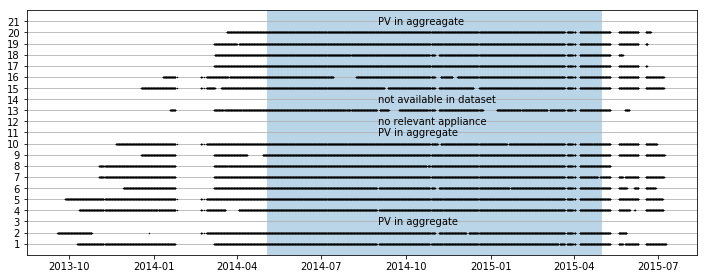

In [6]:
fig, ax = plt.subplots(figsize=(12,4.5))
for column in df_all.columns:
    ax.plot(df_all.index, df_all[column], '.', markersize=1, color='k')
x_box = pd.to_datetime(['2014-05-03', '2014-05-03', '2015-05-02', '2015-05-02'])
ax.fill(x_box, [0,23,23,0], alpha=0.3)
xt = range(1,22,1)
_ = plt.yticks(ticks=xt, labels=xt)
ax.set_ylim([0.0,22.0])
plt.grid(axis='y')
x_text = pd.to_datetime(['2014-09-01'])
plt.text(x_text, 3, 'PV in aggregate', verticalalignment='center')
plt.text(x_text, 14, 'not available in dataset', verticalalignment='center')
plt.text(x_text, 11, 'PV in aggregate', verticalalignment='center')
plt.text(x_text, 12, 'no relevant appliance', verticalalignment='center')
plt.text(x_text, 21, 'PV in aggreagate', verticalalignment='center')

In [7]:
fig.savefig(r'D:\SCCER-Publikation\load-shifting-potential-master\refit-overview.pdf', bbox_inches='tight') 